In [1]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import xesmf as xe
import sys
sys.path.append('../glac1d_meltwater')
import glac1d_toolbox as tb
import routing as routing
import plotting as plotting

/home/olnavy/anaconda3/envs/Olnavy/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


## Regridding benchmark

In [27]:
ds_hice = xr.open_dataset('/Documents/Documents/Cours/PHD/data/Proj_GLAC1D/routed_fwf/GLAC1DHiceF26.nc')
# ds_hice = xr.open_dataset('/nfs/annie/eeymr/work/data/Proj_GLAC1D/routed_fwf/GLAC1DHiceF26.nc')
lon_glac1d, lat_glac1d, t_glac1d = ds_hice.XLONGLOBP5.values, ds_hice.YLATGLOBP25.values, ds_hice.T122KP1.values
lon_glac1d_b, lat_glac1d_b = tb.create_coordinate_edges(lon_glac1d), tb.create_coordinate_edges(lat_glac1d)

ds_lsm = xr.open_dataset('/Documents/Documents/Cours/PHD/data/Proj_GLAC1D/ocean_masks/teadv3.qrparm.omask.nc')
# ds_lsm = xr.open_dataset('/nfs/annie/eeymr/work/data/Proj_GLAC1D/lsm/teadv3.qrparm.omask.nc')
lon_hadcm3, lat_hadcm3, lsm = ds_lsm.longitude.values, ds_lsm.latitude.values, ds_lsm.lsm.values

lon_hadcm3_b, lat_hadcm3_b = tb.create_coordinate_edges(lon_hadcm3), tb.create_coordinate_edges(lat_hadcm3)

ds_pointer = xr.open_dataset('/Documents/Documents/Cours/PHD/data/Proj_GLAC1D/routed_fwf/GLAC1DdrainagePointerF26ka.nc')
# ds_pointer = xr.open_dataset('/nfs/annie/eeymr/work/data/Proj_GLAC1D/routed_fwf/GLAC1DdrainagePointerF26ka.nc')

projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)
# projection_map = ccrs.PlateCarree()

ds_out = xr.Dataset(coords={'lon': (['x'], lon_hadcm3),
                          'lat': (['y'], lat_hadcm3),
                          'lon_b': (['x_b'], lon_hadcm3_b),
                          'lat_b': (['y_b'], lat_hadcm3_b)
                          })

ds_in = xr.Dataset(coords={'lon': (['x'], lon_glac1d),
                         'lat': (['y'], lat_glac1d),
                         'lon_b': (['x_b'], lon_glac1d_b),
                         'lat_b': (['y_b'], lat_glac1d_b),
                         })

#Input

t = np.where(t_glac1d == -21)[0][0]
converted_mask = routing.hi_to_discharge(ds_hice, t, "Volume")
ix, jy = ds_pointer.IX.sel(T40H1=-21).values, ds_pointer.JY.sel(T40H1=-21).values
routed_mask = routing.routing_method(converted_mask, ix, jy)

____ Computation time step : 50.
____ Routing method.


### Bilinear algorithm

Reuse existing file: bilinear_720x720_144x288.nc
Before regriding -> flux : 57378.17 , max : 7141.82
After regriding  -> flux : 57378.17 , max : 35186.39


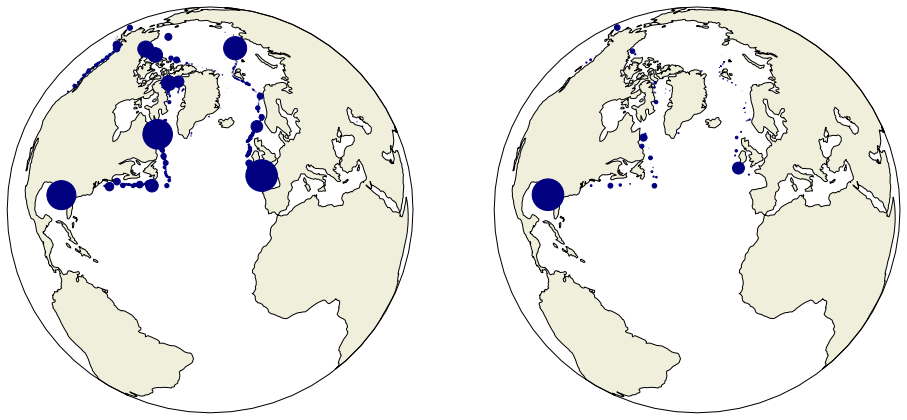

In [20]:
regridder = xe.Regridder(ds_in, ds_out, 'bilinear', reuse_weights=True)

# Output
routed_mask_out = regridder(routed_mask)
routed_mask_out = routed_mask_out*np.nansum(routed_mask)/np.nansum(routed_mask_out)

print(f"Before regriding -> flux : {np.nansum(routed_mask):.2f} , max : {np.nanmax(routed_mask):.2f}")
print(f"After regriding  -> flux : {np.nansum(routed_mask_out):.2f} , max : {np.nanmax(routed_mask_out):.2f}")

# Maps
figMap, (axInit, axRouted) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': projection_map},
                                        figsize=(16, 8))

x, y, s = plotting.scatter_mask(routed_mask)
axInit.scatter(lon_glac1d[x], lat_glac1d[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axInit.set_global()
axInit.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

x, y, s = plotting.scatter_mask(routed_mask_out)
axRouted.scatter(lon_hadcm3[x], lat_hadcm3[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axRouted.set_global()
axRouted.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

### Conservative

Reuse existing file: conservative_720x720_144x288.nc
Before regriding -> sum : 57378.17 , max : 7141.82
After regriding  -> sum : 57378.17 , max : 7165.95


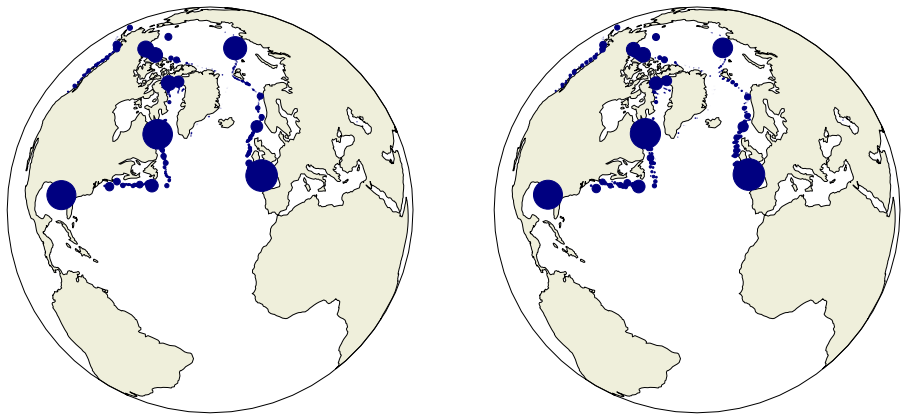

In [19]:
regridder = xe.Regridder(ds_in, ds_out, 'conservative', reuse_weights=True)

# Output
routed_mask_out = regridder(routed_mask)
routed_mask_out = routed_mask_out*np.nansum(routed_mask)/np.nansum(routed_mask_out)

print(f"Before regriding -> sum : {np.nansum(routed_mask):.2f} , max : {np.nanmax(routed_mask):.2f}")
print(f"After regriding  -> sum : {np.nansum(routed_mask_out):.2f} , max : {np.nanmax(routed_mask_out):.2f}")

# Maps
figMap, (axInit, axRouted) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': projection_map},
                                        figsize=(16, 8))

x, y, s = plotting.scatter_mask(routed_mask)
axInit.scatter(lon_glac1d[x], lat_glac1d[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axInit.set_global()
axInit.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

x, y, s = plotting.scatter_mask(routed_mask_out)
axRouted.scatter(lon_hadcm3[x], lat_hadcm3[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axRouted.set_global()
axRouted.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

## Homemade attempt

Before regriding -> sum : 57378.17 , max : 7141.82
After regriding  -> sum : 57378.17 , max : 7141.82


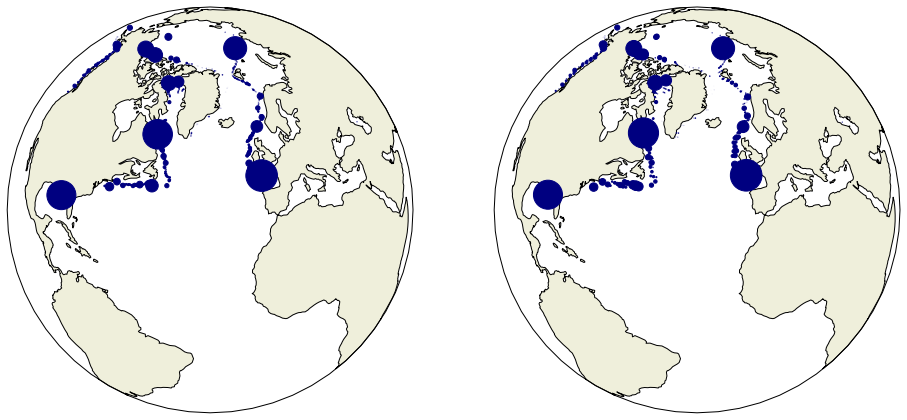

In [24]:
divided_array = np.zeros((routed_mask.shape[0], routed_mask.shape[1]*2))
for i in range(routed_mask.shape[0]):
    for j in range(routed_mask.shape[1]):
        divided_array[i,2*j] = routed_mask[i,j]/2
        divided_array[i,2*j+1] = routed_mask[i,j]/2
                
tab_out = np.zeros((routed_mask_out.shape[0], routed_mask_out.shape[1]))
for i in range(tab_out.shape[0]):
    for j in range(tab_out.shape[1]):
        tab_out[i,j] = np.sum(divided_array[5*i:5*i+5,5*j:5*j+5])
        
# Output

print(f"Before regriding -> sum : {np.nansum(routed_mask):.2f} , max : {np.nanmax(routed_mask):.2f}")
print(f"After regriding  -> sum : {np.nansum(tab_out):.2f} , max : {np.nanmax(tab_out):.2f}")

# Maps
figMap, (axInit, axRouted) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': projection_map},
                                        figsize=(16, 8))

x, y, s = plotting.scatter_mask(routed_mask)
axInit.scatter(lon_glac1d[x], lat_glac1d[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axInit.set_global()
axInit.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

x, y, s = plotting.scatter_mask(tab_out)
axRouted.scatter(lon_hadcm3[x]-180, lat_hadcm3[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axRouted.set_global()
axRouted.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

## Shifting Algorithm

These points are now to be shifted in the sea : we consider the closest sea points of the discharge point and we distribute the meltwater rate. To determine the closest neighbours, I propose 4 different algorithms to do so :  (double longitude / simple longitude) and (square / cross).

### Square simple longitude

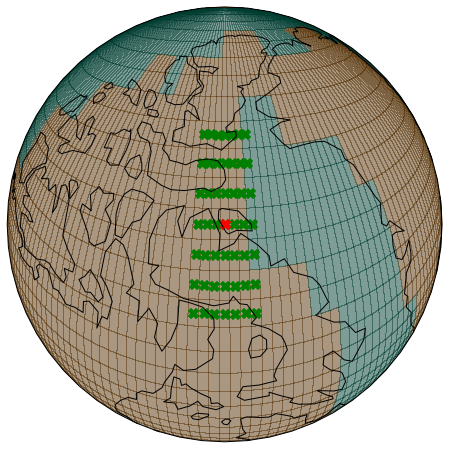

In [30]:
i_can, j_can = 224, 130

projection_map = ccrs.NearsidePerspective(central_longitude=lon_hadcm3[i_can], central_latitude=lat_hadcm3[j_can],
                                            satellite_height=300000)

i_sea_points, j_sea_points, lon_sea_points, lat_sea_points = [], [], [], []
radius = 3

for i in range(-radius, radius +1):
    for j in range(-radius,radius +1):
        i_sea_points.append(i_can + i), j_sea_points.append(j_can + j)
        lon_sea_points.append(lon_hadcm3[i_can + i]), lat_sea_points.append(lat_hadcm3[j_can + j])
            
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMap.scatter(lon_sea_points, lat_sea_points, transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axMap.scatter(lon_hadcm3[i_can], lat_hadcm3[j_can], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axMap.coastlines()
axMap.set_global()

### Square double longitude

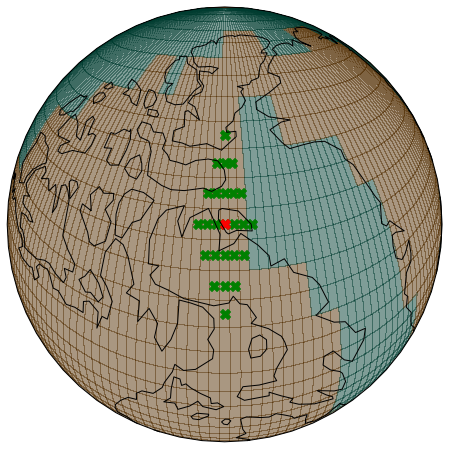

In [32]:
i_can, j_can = 224, 130

projection_map = ccrs.NearsidePerspective(central_longitude=lon_hadcm3[i_can], central_latitude=lat_hadcm3[j_can],
                                            satellite_height=300000)

i_sea_points, j_sea_points, lon_sea_points, lat_sea_points = [], [], [], []
radius = 3

for i in range(-radius, radius +1):
    for j in range(-(radius//2),(radius)//2+1):
        i_sea_points.append(i_can + i), j_sea_points.append(j_can + j)
        lon_sea_points.append(lon_hadcm3[i_can + i]), lat_sea_points.append(lat_hadcm3[j_can + j])
            
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMap.scatter(lon_sea_points, lat_sea_points, transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axMap.scatter(lon_hadcm3[i_can], lat_hadcm3[j_can], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axMap.coastlines()
axMap.set_global()

### Cross simple longitude

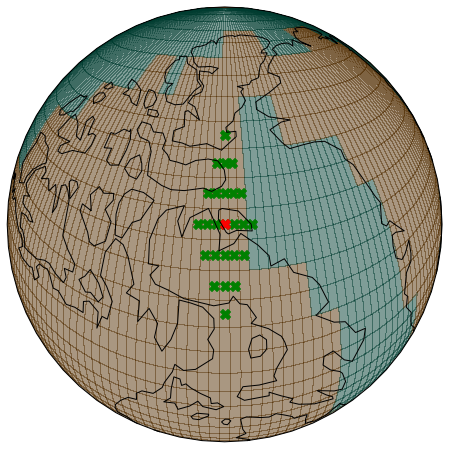

In [33]:
i_can, j_can = 224, 130

projection_map = ccrs.NearsidePerspective(central_longitude=lon_hadcm3[i_can], central_latitude=lat_hadcm3[j_can],
                                            satellite_height=300000)

i_sea_points, j_sea_points, lon_sea_points, lat_sea_points = [], [], [], []
radius = 3

for i in range(-radius, radius +1):
    for j in range(-(radius - abs(i)),(radius-abs(i)+1)):
        i_sea_points.append(i_can + i), j_sea_points.append(j_can + j)
        lon_sea_points.append(lon_hadcm3[i_can + i]), lat_sea_points.append(lat_hadcm3[j_can + j])
            
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMap.scatter(lon_sea_points, lat_sea_points, transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axMap.scatter(lon_hadcm3[i_can], lat_hadcm3[j_can], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axMap.coastlines()
axMap.set_global()

### Cross double longitude

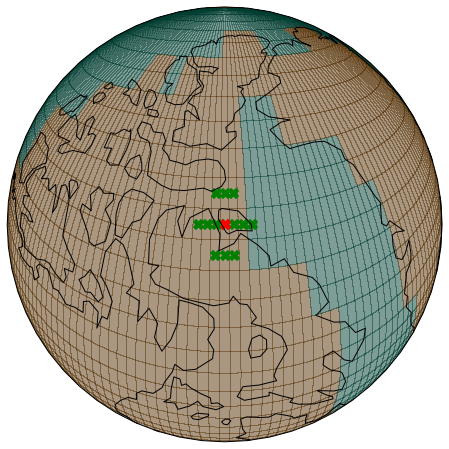

In [34]:
i_can, j_can = 224, 130

projection_map = ccrs.NearsidePerspective(central_longitude=lon_hadcm3[i_can], central_latitude=lat_hadcm3[j_can],
                                            satellite_height=300000)

i_sea_points, j_sea_points, lon_sea_points, lat_sea_points = [], [], [], []
radius = 3

for i in range(-radius, radius +1):
    for j in range(-((radius - abs(i))//2),(radius-abs(i))//2+1):
        i_sea_points.append(i_can + i), j_sea_points.append(j_can + j)
        lon_sea_points.append(lon_hadcm3[i_can + i]), lat_sea_points.append(lat_hadcm3[j_can + j])
            
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMap.scatter(lon_sea_points, lat_sea_points, transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axMap.scatter(lon_hadcm3[i_can], lat_hadcm3[j_can], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axMap.coastlines()
axMap.set_global()